In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [29]:
try:
    tfe.enable_eager_execution()
except ValueError:
    # Hide the annoying lack of idem-potency.
    pass

In [30]:
def make_block_linear_operator(block_sizes, variable=tfe.Variable):
    dim = sum(block_sizes)
    psd_args = dict(
        is_non_singular=True,
        is_self_adjoint=True,
        is_positive_definite=True,
    )
    diagonal = tf.zeros([dim])
    variables = []

    offset = 0
    for block_size in block_sizes:
        pad_before = offset
        pad_after = dim - (offset + block_size)
        v = variable(0.)
        variables.append(v)
        diagonal += tf.pad(tf.exp(v) * tf.ones([block_size]),
                           [[pad_before, pad_after]])
        offset += block_size
    linop = tf.linalg.LinearOperatorDiag(diagonal, **psd_args)

    offset = 0
    for block_size in block_sizes:
        pad_before = offset
        pad_after = dim - (offset + block_size)
        v = variable(.3)
        variables.append(v)
        u = tf.pad(v * tf.ones([block_size, 1]),
                   [[pad_before, pad_after], [0, 0]])
        linop = tf.linalg.LinearOperatorLowRankUpdate(linop, u=u, v=u, **psd_args)
        offset += block_size
    return linop, variables 


K, variables = make_block_linear_operator([3, 5, 5, 1])

In [31]:
K.log_abs_determinant()

<tf.Tensor: id=22971, shape=(), dtype=float32, numpy=1.0683217>

In [32]:
# val_and_grad_fn = tfe.value_and_gradients_function(lambda K: K.log_abs_determinant())
# val_and_grad_fn(K)

In [33]:
K_tensor = K.matmul(tf.eye(K.shape[0].value))

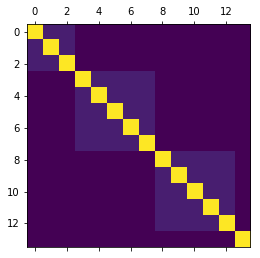

In [34]:
plt.matshow(K_tensor);

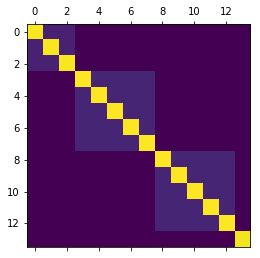

In [35]:
plt.matshow(tf.linalg.expm(K_tensor));

In [36]:
%time big_K, big_variables = make_block_linear_operator([4096] * 10)

CPU times: user 4.13 s, sys: 76 ms, total: 4.21 s
Wall time: 4.12 s


In [37]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [38]:
# %lprun -f make_block_linear_operator make_block_linear_operator([4096] * 10)

In [39]:
big_K.shape

TensorShape([Dimension(40960), Dimension(40960)])

In [40]:
np.product(big_K.shape).value / 1e9

1.6777216

In [41]:
len(big_variables)

20

In [42]:
%time big_K.log_abs_determinant()

CPU times: user 508 ms, sys: 4 ms, total: 512 ms
Wall time: 512 ms


<tf.Tensor: id=30499, shape=(), dtype=float32, numpy=59.125305>

In [43]:
# tf.linalg.expm(big_K)

8

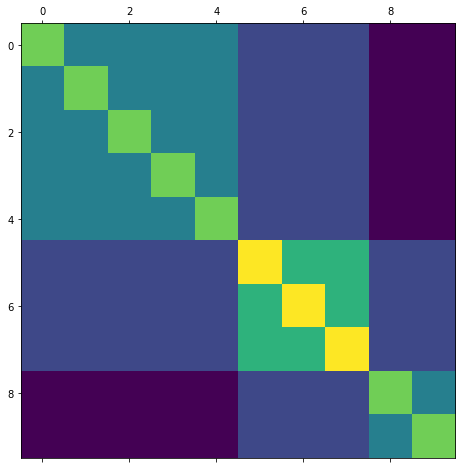

In [44]:
block_boundaries = [0, 5, 8, 10]
# block_boundaries = [0]
# block_boundaries.append(block_boundaries[-1] + 784 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)
# block_boundaries.append(block_boundaries[-1] + 10 * 10)
# block_boundaries.append(block_boundaries[-1] + 10)



def outer(v):
    return tf.matmul(tf.reshape(v, (-1, 1)),
                     tf.reshape(v, (1, -1)))


def parametrized_precision(block_boundaries):
    variables = []
    n_params = block_boundaries[-1]
    K = tf.zeros(shape=(n_params, n_params))
    for i, j in zip(block_boundaries, block_boundaries[1:]):
        # Diagonal for the current block
        diag_mask_i = np.zeros(n_params, dtype=np.float32)
        diag_mask_i[i:j] = 1
        diag_mask_i = tf.constant(diag_mask_i)
        K_i_var = tfe.Variable(0.5, dtype=np.float32)
        K_i = tf.diag(tf.exp(K_i_var) * diag_mask_i)
        variables.append(K_i_var)
        K += K_i
        
        # Rank-one for the current parameter block
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tfe.Variable(1, dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    for i, j in zip(block_boundaries, block_boundaries[2:]):
        # Rank-one for consecutive blocks interactions
        ro_mask_i = np.zeros(n_params, dtype=np.float32)
        ro_mask_i[i:j] = 1
        ro_mask_i = tf.constant(ro_mask_i)
        ro_var_i = tfe.Variable(1., dtype=np.float32)
        ro_i = outer(ro_var_i * ro_mask_i)
        variables.append(ro_var_i)
        K += ro_i
    return variables, K

variables, K = parametrized_precision(block_boundaries)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(K)
len(variables)

In [45]:
tf.linalg.det(K)

<tf.Tensor: id=30616, shape=(), dtype=float32, numpy=18083.262>

<tf.Tensor: id=30618, shape=(10,), dtype=float32, numpy=
array([ 1.6487198,  1.6487209,  1.648721 ,  1.6487212,  1.6487212,
        1.6487212,  1.6487213,  4.268642 ,  8.341459 , 15.3360615],
      dtype=float32)>

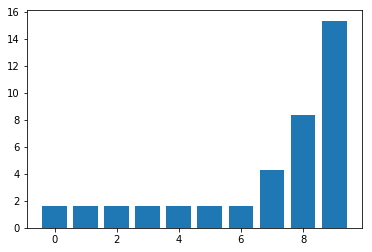

In [46]:
eigvals = tf.linalg.eigh(K)[0]
plt.bar(np.arange(K.numpy().shape[0]), eigvals)
eigvals

In [47]:
C = tf.linalg.inv(K)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(C)

In [48]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance


model = MultivariateNormalFullCovariance(loc=tf.zeros([C.shape[0]], dtype=np.float32), covariance_matrix=C)

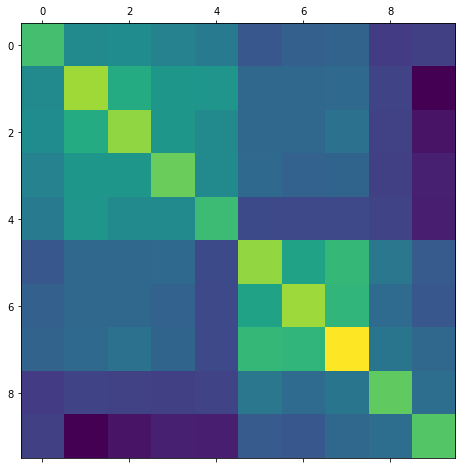

In [49]:
data = model.sample(100)
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(tf.linalg.inv(tf.matmul(tf.transpose(data), data)));

In [50]:
# from sklearn.covariance import graph_lasso

# gl = graph_lasso(np.asarray(tf.matmul(tf.transpose(data), data)), 1)
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.matshow(gl[1])

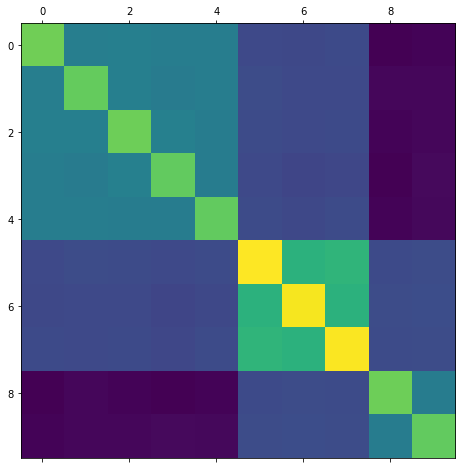

In [51]:
data_large = model.sample(10000)
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(tf.linalg.inv(tf.matmul(tf.transpose(data_large), data_large)));